## Introduction

[In the last post of this series](https://andpalmier.github.io/posts/ml-with-phishing-ep1/), we analyzed how some of the parameters of a decision tree could improve the accuracy of the model when classifying phishing sites. In this second post, we will perform a similar analysis, but with a different classifier: random forest.

A random forest classifier is made of a number of decision trees which operate as an ensemble. The idea behind random forest is simple: every tree in the forest works independently as a classifier; then - based on the task which was submitted - the prediction of the forest is either the average of the predictions of the trees or the one with the most votes.

This approach works better if the correlation between the trees in the forest is low: if a low number of trees in the forest make a mistake, the majority of the forest will correct it.

## Random forest against phishing

We will start the analysis importing the libraries and dataset which are going to be used in this post. As for the previous episode, I used a smaller version of a dataset which was created for [this study](https://www.sciencedirect.com/science/article/pii/S0020025519300763). 

In [16]:
import numpy as np
from matplotlib.legend_handler import HandlerLine2D
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load the data from a CSV file
train_data = np.genfromtxt('phishing_smaller.csv', delimiter=',', dtype=np.int32)

Our dataset contains 10.000 samples and 11 columns, where 10 represents the features and the last one is the label of the sample.

As for the previous episode, I used a smaller version of a dataset which was created for [this study](https://www.sciencedirect.com/science/article/pii/S0020025519300763). You can find the version of the dataset used in this post [in this GitHub repo](https://github.com/andpalmier/MLWithPhishing), which contains also information about the features selected and the code of this post in form of a Jupyter notebook.

In [17]:
# inputs are in all columns except the last one
inputs = train_data[:,:-1]

# outputs in the last column
outputs = train_data[:, -1]

`StratifiedKFold` will be used in order to keep the frequency of the classes constant during our K-fold cross-validation. It is important to notice that `random_state` is set not only for k-fold, but also in the random forest classifier: so that it will reproduce the same setup for all the iterations of the model.

In [18]:
from sklearn.model_selection import StratifiedKFold

# use 10-fold with random_state set to 0
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

As in the other post, we will use AUC (Area Under Curve) to evaluate the accuracy of our classifier; so let's import the required library and define the array to store the accuracy during the iterations with the different folds:

In [19]:
# library for evaluating the classifier
import sklearn.metrics as metrics

# list to store the accuracy during k-fold cross-validation
accuracy = np.array([])

We will now loop through the 10 combinations of splits and use them to train and evaluate 10 different models. The accuracy of these models will be stored in the `accuracy` list.

In [20]:
# loop with splits
for train_index, test_index in skf.split(inputs, outputs):
    
    # 9 folds used for training
    x_train, x_test = inputs[train_index], inputs[test_index]
    # 1 fold for testing
    y_train, y_test = outputs[train_index], outputs[test_index]

    # Create the classifier 
    # random_state is to keep same setup
    # n_jobs is -1 to use all the processors
    rf = RandomForestClassifier(random_state=0,n_jobs=-1)
    
    # Train the classifier
    rf.fit(x_train, y_train)
    
    # Test the classifier
    predictions = rf.predict(x_test)
    false_positives, true_positives, thresholds = \
        metrics.roc_curve(y_test, predictions)
    
    # calculate classifier accuracy
    ROC_AUC = metrics.auc(false_positives, true_positives)
    accuracy = np.append(accuracy,ROC_AUC)

The `n_jobs` parameter of the classifier defines the number of jobs to run in parallel over the trees.If set to `None` (which is the case by default) it means 1, while if set to -1 it will use all processors.

In order to evaluate our model trained with k-folds, we will take the mean of the accuracy of the 10 values generated in the previous steps:

In [21]:
print("ROC AUC: "+str(np.mean(accuracy)))

ROC AUC: 0.922092384769539


The accuracy is already quite good. In fact, it is better than the one obtained with the 'vanilla' decision tree. Let's see which parameters could be used to improve the performance of our random forest.

## Getting ready

Before continuing with the analysis, considering that some actions are going to be repeated (training, testing and evaluate the classifiers) let's wrap some of these operations in a function which will be called accordingly.

Our `magic` function will take in input a list of classifiers and two lists for the results of the training and testing; the latters will be filled with the values of AUC during the k-fold iterations and will be returned at the end of the function.

In [22]:
# function which takes as input a list of classifiers
# and two lists for the accuracy of the classifiers
# these 2 lists will be returned in the end
def magic(list_classifiers, list_train_accuracy, list_test_accuracy):
    
    # create the folds (always the same with random_state = 0)
    StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    for train_index, test_index in skf.split(inputs, outputs):
        
        x_train, x_test = inputs[train_index], inputs[test_index]
        y_train, y_test = outputs[train_index], outputs[test_index]
        
        # iterate through the classifiers
        for i in range(0,len(list_classifiers)):
            
            classifier = list_classifiers[i]
            
            classifier.fit(x_train, y_train)
            
            # get train accuracy
            predictions = classifier.predict(x_train)
            
            false_positives, true_positives, threshold = \
                metrics.roc_curve(y_train,predictions)
            ROC_AUC = metrics.auc(false_positives,true_positives)
            list_train_accuracy[i] = np.append(list_train_accuracy[i],ROC_AUC)
            
            # get test accuracy
            predictions = classifier.predict(x_test)
            
            false_positives, true_positives, threshold = \
                metrics.roc_curve(y_test,predictions)
            ROC_AUC = metrics.auc(false_positives,true_positives)
            list_test_accuracy[i] = np.append(list_test_accuracy[i],ROC_AUC)
    
    # return the array of accuracy of the classifiers
    return list_train_accuracy,list_test_accuracy

## Choose the best criterion

If you want to see the full list of parameters available to tune the random forest classifier, please refer to [the scikit-learn documentation for random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

We will start our analysis with the `criterion` parameter, which represents the function that will be used to measure the quality of a split. The supported criteria are `gini` (for [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity)) and `entropy` (for [information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees)), we will now create two classifiers having different `criterion`, to see which one has the best accuracy with our dataset.

In [23]:
# create the two classifiers
gini_classifier = RandomForestClassifier(random_state=0,criterion="gini", n_jobs=-1)
entropy_classifier = RandomForestClassifier(random_state=0,criterion="entropy", n_jobs=-1)

# lists to store variables to pass to the "magic" function
classifiers = [gini_classifier,entropy_classifier]
train_accuracies = [np.array([]),np.array([])]
test_accuracies = [np.array([]),np.array([])]

# in this iteration we are interested only in the test results
_,test_results = magic(classifiers,train_accuracies,test_accuracies)
print("Accuracy of gini classifier: "+str(np.mean(test_results[0])))
print("Accuracy of entropy classifier: "+str(np.mean(test_results[1])))

Accuracy of gini classifier: 0.922092384769539
Accuracy of entropy classifier: 0.9227925851703407


The results listed above shows that, even if the difference is not much (0.70%), the classifier using the entropy function as a criterion for the split outperforms the one using the gini function. It is interesting to note that the gini criterion is the one used by default for decision trees in sklearn.

## Tuning: n_estimators

Now we are going to tune `n_estimators`, which represents the total number of trees in the forest. Having a high number of trees has usually the advantage of increasing the overall accuracy of the model, however it will make the train phase slower due to the fact that a higher number of trees needs to be trained. 
By default, `n_estimators` is set to 100 (before version 0.22 of sklearn it was 10).

In the following example, we will create and evaluate 8 different classifiers having `n_estimators` set to 1, 3, 6, 10, 25, 50, 75, 100, 125 and 100.

In [24]:
# number of estimators to use in the 10 classifiers
n_estimators = [1,3,6,10,25,50,75,100,125,150]

# lists to use for the "magic" function
classifiers = []
train_accuracies = []
test_accuracies = []

for i in n_estimators:
    
    # create classifier with appropriate n_estimators
    classifier = RandomForestClassifier(random_state=0,n_jobs=-1,n_estimators=i)
    classifiers.append(classifier)
    
    # metrics to evaluate the classifier
    train_accuracies.append(np.array([]))
    test_accuracies.append(np.array([]))

# let the magic happen
train_results,test_results = magic(classifiers,test_accuracies,train_accuracies)

The `magic` function returned two lists containing the accuracy for every iteration of k-fold for every classifier; now the average of the accuracy for each random forest will be taken, in order to show the results in a chart using `matplotlib`. 

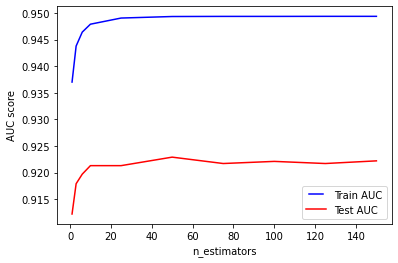

In [25]:
# store the averages of the classifiers for training and testing
avg_train=[]
avg_test=[]

# loop for every classifier we created
for i in range(0,len(train_results)):
    
    # average the results for every classifier
    avg_train.append(np.mean(train_results[i]))
    avg_test.append(np.mean(test_results[i]))
    
# blue line for train AUC
line1, = plt.plot(n_estimators, avg_train, 'b', label="Train AUC")
# red line for test A=UC
line2, = plt.plot(n_estimators, avg_test, 'r', label="Test AUC")

# print chart
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

For our dataset, the best performance in the tests is achieved when using 50 trees. If we further increase the number of trees, the AUC in the tests will slightly decrease. The same number of trees allows the classifier to reach the maximum accuracy during training (almost 95%).

## Tuning: max_depth

`max_depth` is used to specify the maximum depth of each tree in the forest. As we saw in our previous analysis, the deeper the tree, the more splits it has, thus it will be able to capure more information about the data.

The ranges of the `max_depth` for our analysis will be between 1 and 32. As in the previous paragraph, a line chart will be used to show the results. 

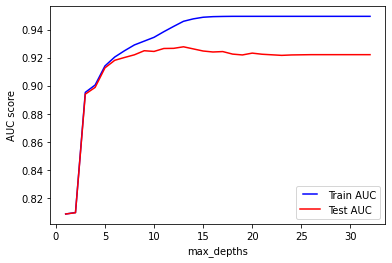

In [26]:
# max depths to use in the classifiers
list_max_depth = np.linspace(1, 32, 32, endpoint=True)

# lists to use in the magic function
classifiers = []
train_accuracies = []
test_accuracies = []

for i in list_max_depth:
    
    # create classifier with appropriate max_depth
    classifier = RandomForestClassifier(random_state=0,n_jobs=-1,max_depth=i)
    classifiers.append(classifier)
    
    # metrics to evaluate the classifier
    train_accuracies.append(np.array([]))
    test_accuracies.append(np.array([]))

# let the magic happen
train_results,test_results = magic(classifiers,test_accuracies,train_accuracies)

# store the averages of the classifiers for training and testing
avg_training=[]
avg_testing=[]

for i in range(0,len(train_results)):
    
    # average the results for every classifier
    avg_training.append(np.mean(train_results[i]))
    avg_testing.append(np.mean(test_results[i]))
    
# blue line for train AUC
line1, = plt.plot(list_max_depth, avg_training, 'b', label="Train AUC")
# red line for test AUC
line2, = plt.plot(list_max_depth, avg_testing, 'r', label="Test AUC")

# print chart    
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depths')
plt.show()

It is interesting to note the spike that is generated when increasing the `max_depth` of the trees in the forest from 2 to 3: the AUC in training and testing improves of almost 10% (from around 0.8 to almost 0.9).
As expected, `max_depth` contribute to an improvement of the overall accuracy of the model, until around 13, when the test AUC reach its peak. The peak for the train AUC is reached at 15, and remains stable even when using trees with 32 splits.

## Tuning: min_samples_split

The next parameter to be tuned is `min_samples_split`: it represents the minimum number of samples required to split a node in the trees of the forest. This parameter can be an integer (its default value is 2), but also a float: so that `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split.

In this experiment will train and evaluate 10 classifiers having `min_samples_split` between 0.1 and 1.0.

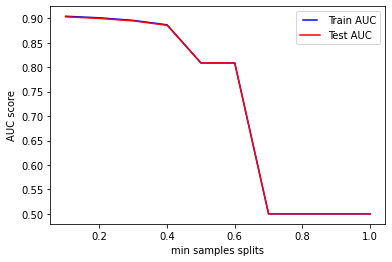

In [27]:
# min samples splits from 10% to 100%
list_min_samples_splits = np.linspace(0.1,1.0,10,endpoint=True)

# lists to use in the magic function
classifiers = []
train_accuracies = []
test_accuracies = []

for i in list_min_samples_splits:
    
    # create classifier with appropriate max_depth
    classifier = RandomForestClassifier(random_state=0,n_jobs=-1,min_samples_split=i)
    classifiers.append(classifier)
    
    # metrics to evaluate the classifier
    train_accuracies.append(np.array([]))
    test_accuracies.append(np.array([]))

# let the magic happen
train_results,test_results = magic(classifiers,test_accuracies,train_accuracies)

# store the averages of the classifiers for training and testing
avg_training=[]
avg_testing=[]

for i in range(0,len(train_results)):
    
    # average the results for every classifier
    avg_training.append(np.mean(train_results[i]))
    avg_testing.append(np.mean(test_results[i]))
    
# print chart    
line1, = plt.plot(list_min_samples_splits, avg_training, 'b', label="Train AUC")
line2, = plt.plot(list_min_samples_splits, avg_testing, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples splits')
plt.show()

We can see from the results in the chart that for values of `min_samples_split` above 0.7, our model does not learn enough information from the data: this is because too many samples are required at each node in order to be splitted. For high values of `min_samples_split` the performances are equally bad (0.5 of AUC) during train and test.

## Tuning: min_samples_leaf

Similarly to the previous parameter, `min_samples_leaf` it is used to specify the minimum number of samples which are required to be in a leaf of the trees in our forest. Again, this parameter can be an integer (also in this case its default value is 2) and a float, so that `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node.

The classifiers which are defined in the following lines have `min_samples_split` between 0.05 and 0.5 (maximum number allowed).

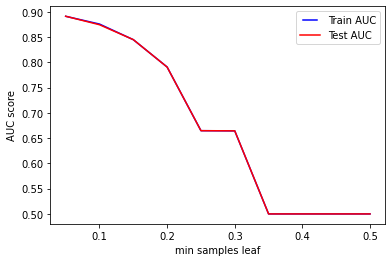

In [28]:
# min samples leaf from 5% to 50%
list_min_samples_leaf = np.linspace(0.05,0.5,10,endpoint=True)

# lists to use in the magic function
classifiers = []
train_accuracies = []
test_accuracies = []

for i in list_min_samples_leaf:
    
    # create classifier with appropriate max_depth
    classifier = RandomForestClassifier(random_state=0,n_jobs=-1,min_samples_leaf=i)
    classifiers.append(classifier)
    
    # metrics to evaluate the classifier
    train_accuracies.append(np.array([]))
    test_accuracies.append(np.array([]))

# let the magic happen
train_results,test_results = magic(classifiers,test_accuracies,train_accuracies)

# store the averages of the classifiers for training and testing
avg_training=[]
avg_testing=[]

for i in range(0,len(train_results)):
    
    # average the results for every classifier
    avg_training.append(np.mean(train_results[i]))
    avg_testing.append(np.mean(test_results[i]))
    
# print chart    
line1, = plt.plot(list_min_samples_leaf, avg_training, 'b', label="Train AUC")
line2, = plt.plot(list_min_samples_leaf, avg_testing, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

The results are similar to the previous analysis: increasing the value of `min_samples_leaf` cause the model to fail in learning from the data and decrease its performance to the point of obtaining AUC of 0.5 dunring train and test when `min_samples_leaf` is more than 0.35.

## Tuning: max_features

We will conclude this analysis of the random forest classifier with `max_features`. This parameter represents the number of features which are going to be considered when looking for the best possible split.
Its default value is *None*, so that `max_features` is set to the total number of features. Considering that our dataset has 10 features for every sample, we will train and test 10 classifiers having `max_features` between 1 and 10.


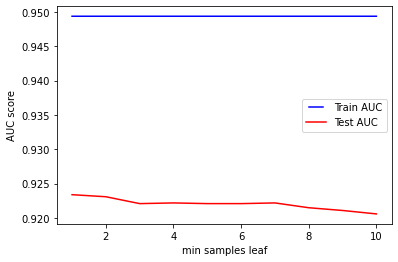

In [29]:
# max features from 1 to 10
list_max_features = range(1,11)

# lists to use in the magic function
classifiers = []
train_accuracies = []
test_accuracies = []

for i in list_max_features:
    
    # create classifier with appropriate max_depth
    classifier = RandomForestClassifier(random_state=0,n_jobs=-1,max_features=i)
    classifiers.append(classifier)
    
    # metrics to evaluate the classifier
    train_accuracies.append(np.array([]))
    test_accuracies.append(np.array([]))

# let the magic happen
train_results,test_results = magic(classifiers,test_accuracies,train_accuracies)

# store the averages of the classifiers for training and testing
avg_training=[]
avg_testing=[]

for i in range(0,len(train_results)):
    
    # average the results for every classifier
    avg_training.append(np.mean(train_results[i]))
    avg_testing.append(np.mean(test_results[i]))
    
# print chart    
line1, = plt.plot(list_max_features, avg_training, 'b', label="Train AUC")
line2, = plt.plot(list_max_features, avg_testing, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

The resulting chart shows that the accuracy of the model does not improve when increasing `max_features` and it causes an overfitting for all the values in the experiment. A similar result was obtained when tuning the same parameter for the decision tree. As stated in the sklearn documentation of random forest classifiers: *'the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features'*.

## Conclusion

In this post we conducted an experiment to evaluate how some of the parameters available to tune random forest classifiers affect the performance of the model when trying to detect a phishing page. The parameters explored were: `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf` and `max_features`.

I will mention again that this is not the proper way of tuning the parameters for a random forest: the best approach would be to extend parameters search using `RandomizedSearchCV` provided by sklearn.

---

**NOTE: I am far from being an expert and I like learning new things. If you have comments/suggestions, feel free to ping me on Twitter or Keybase (I have the same handle @andpalmier).**